In [1]:
import os
import django

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "SciNewsSite.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()
from blog.models import Blog, Word
from matplotlib import pyplot as plt
from django.db.models import Q
import numpy as np
import pandas as pd
import datetime
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12.8, 7.2)

## 不同主题关注度分析
本部分以月为单位，可视化关于科技产品、人工智能、财经（科技企业的财经）方面的新闻条目占比变化。通过观察新闻条目的变化，能够推断出社会对不同主题新闻的关注度随时间的变化。
经统计，新闻发布时间最早为2022-04-11 21:41:04， 最晚为2023-08-25 20:59:26， 共计17个月。

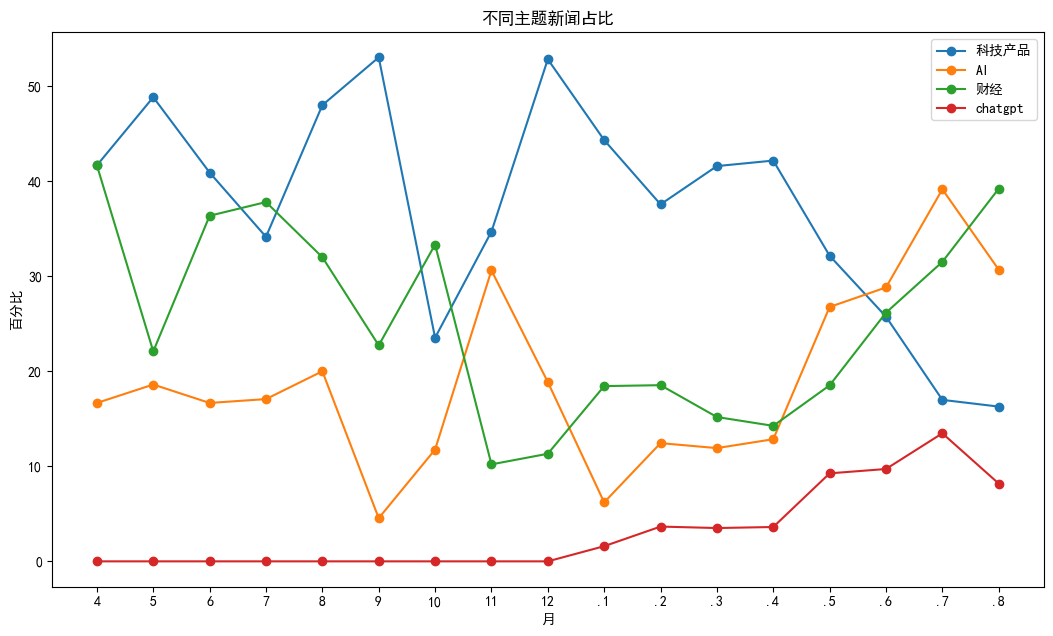

In [2]:
date_ls = [(2022, 4), (2022, 5), (2022, 6), (2022, 7), (2022, 8), (2022, 9), (2022, 10), (2022, 11), (2022, 12),
           (2023, 1), (2023, 2), (2023, 3), (2023, 4), (2023, 5), (2023, 6), (2023, 7), (2023, 8), (2023, 9)]
product_arr = np.zeros(len(date_ls) - 1, dtype=np.float32)
ai_arr = np.zeros(len(date_ls) - 1, dtype=np.float32)
finance_arr = np.zeros(len(date_ls) - 1, dtype=np.float32)
chatgpt_arr = np.zeros(len(date_ls) - 1, dtype=np.float32)
chatgpt_words = Word.objects.filter(Q(word__iexact='chatgpt') | Q(word='大模型'))
chatgpt_blogs = []
for word in chatgpt_words:
    chatgpt_blogs.extend([int(blog) for blog in word.blogs.split(',')])
chatgpt_blogs = set(chatgpt_blogs)
# 按月计算比例
for i in range(len(date_ls) - 1):
    date_start = datetime.datetime(date_ls[i][0], date_ls[i][1], 1, 0, 0, 0)
    date_end = datetime.datetime(date_ls[i + 1][0], date_ls[i + 1][1], 1, 0, 0, 0)
    blog_ls = Blog.objects.filter(create_time__gte=date_start, create_time__lt=date_end)
    product_arr[i] = blog_ls.filter(theme='科技产品').count() / blog_ls.count()
    ai_arr[i] = blog_ls.filter(theme='AI').count() / blog_ls.count()
    finance_arr[i] = blog_ls.filter(theme='财经').count() / blog_ls.count()
    chatgpt_arr[i] = blog_ls.filter(id__in=chatgpt_blogs).count() / blog_ls.count()

# 绘制折线图
x = ["4", "5", "6", "7", "8", "9", "10", "11", "12", ".1", ".2",
     ".3"
    , ".4", ".5", ".6", ".7", ".8"]
plt.plot(x, product_arr * 100, label='科技产品', marker='o')
plt.plot(x, ai_arr * 100, label='AI', marker='o')
plt.plot(x, finance_arr * 100, label='财经', marker='o')
plt.plot(x, chatgpt_arr * 100, label='chatgpt', marker='o')
plt.xlabel('月')
plt.ylabel('百分比')
plt.title('不同主题新闻占比')
plt.legend()
plt.show()

上述代码首先将时间范围划分为17个月，并以月为单位统计对应的新闻数，再计算各个月中不同主题新闻占该月新闻总数的百分比，最后利用matplotlib绘制折线图。
（1）AI主题新闻占比总体呈上升趋势，科技产品类新闻占比总体呈下降趋势。这一现象在2023年1月之后越发明显。结合ChatGPT占比从2023年1月开始稳步上升的现象，可以推断这两个主题新闻占比的变化趋势与ChatGPT的爆火有很大关系。
（2）财经类新闻占比曲线总体为“U”型。低谷期与2022年疫情期间科技企业金融情况不景气有关。而2023年1月之后占比稳步提升，推断与ChatGPT带来的大模型投资潮有关。
### 结论
自2023年年初，以ChatGPT为代表的大模型的横空出世深刻吸引了公众和媒体的关注，并引发新的一股人工智能热与投资热。

## 科技新闻关键词词频分析
上一部分分析不同主题新闻在时间维度的变化。本部分对数据进行整体分析，通过绘制词云图，可视化不同关键词在科技新闻中的总体出现频率，借此分析近年科技新闻热点。

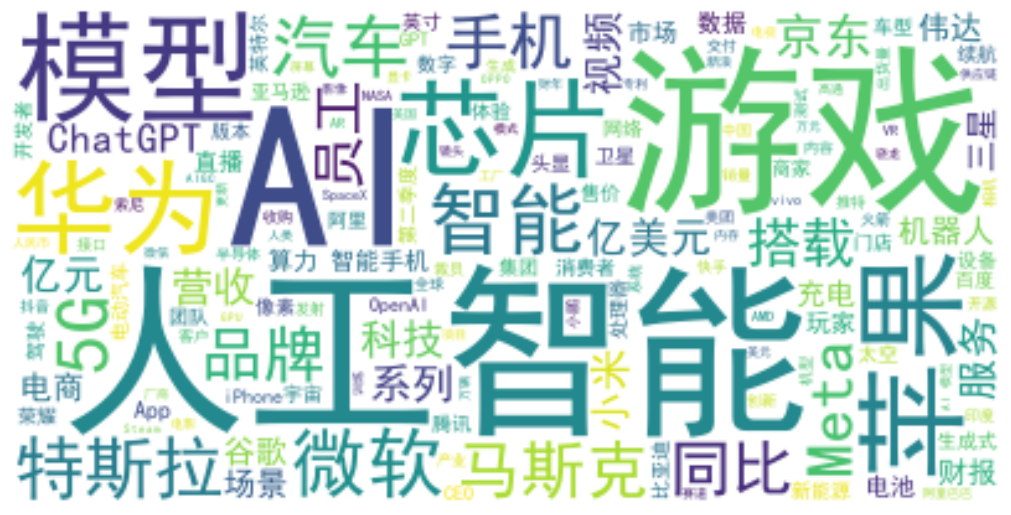

In [3]:
from wordcloud import WordCloud

stopwords = []  # 停用词
with open('stopwords.txt', 'r') as s_f:
    stopwords.extend(s_f.read().split('\n'))
stopwords.extend([' ', '\n', '\t'])

words_df = pd.read_csv('keywords.csv').astype(str)  # 载入预先提取好的关键词
kw_ls = words_df[~words_df['kw'].isin(stopwords)]  # 滤去停用词

wc = WordCloud(font_path=r"C:\Windows\Fonts\simhei.ttf",  # 字体
               background_color='white',
               max_words=1000)  # 词云显示的最大词数
wc.generate(' '.join(kw_ls['kw'].tolist()))
#show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

注：每次生成词云图不同单词位置会有差异，但相对大小不变

上述代码首先加载预生成的关键词，并滤除停用词。接着利用这些关键词生成词云图。
词云图显示，科技新闻的关键词中，“人工智能”“AI”“模型”“智能”字体较大，这与近些年的人工智能热潮高度一致。接着是“游戏”，透露出当今媒体向适应年轻人的消费兴趣爱好的方向转型。紧随其后的是“芯片”，也反映了我国媒体及民众对于我国卡脖子问题的关注与解决这一问题的期待。“苹果”“华为”“微软”等公司名称紧随其后，是各个国家的科技龙头企业。频率再小一些的便是最近的科技热词，像是“5G”“ChatGPT”等。

### 结论
近年科技新闻热点主要在人工智能、娱乐、微电子等领域，与近期国际政治形势、科技进展及社会风潮保持一致。

## 基于KMeans聚类的新闻内容分析
上面从较为宏观的角度对新闻进行分析，本部分把重点放在新闻的内容上，观察近期科技新闻能否清晰地分成几个类别。

Building prefix dict from the default dictionary ...
Loading model from cache C:\Temp\jieba.cache
Loading model cost 0.403 seconds.
Prefix dict has been built successfully.
D:\anaconda\envs\django\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


8

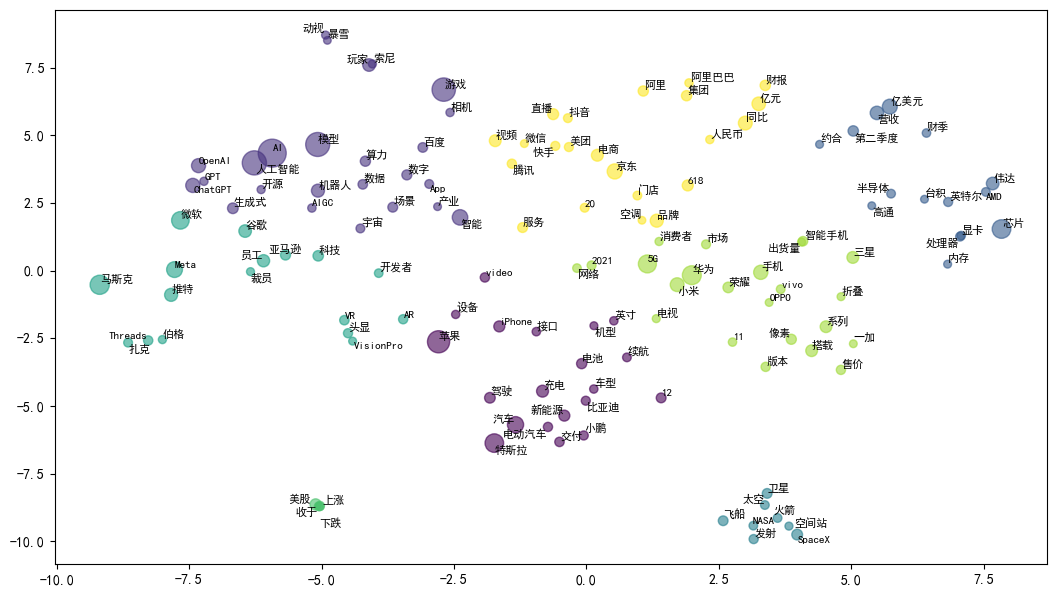

In [4]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import gensim
import jieba.analyse
from collections import defaultdict
from adjustText import adjust_text

word_ls = []
for blog in Blog.objects.all():
    text = blog.text
    temp_ls = []
    # 与词云图不同，这次每个文章最多提取5个关键词
    tags = jieba.analyse.extract_tags(text, topK=5, withWeight=True)
    for word, weight in tags:
        if word not in stopwords:  # 滤除停用词
            temp_ls.append(word)
    word_ls.append(temp_ls)

gensim_model = gensim.models.Word2Vec(word_ls, min_count=30, seed=0, epochs=100, window=20)  # 转化为词向量
words = list(gensim_model.wv.key_to_index)  # 存储标签

# 统计词频
frequency_dic = defaultdict(int)
for sub_ls in word_ls:
    for word in sub_ls:
        frequency_dic[word] += 1  # 首先建立所有词频的字典
words = list(set(words))
frequency = [frequency_dic[word] for word in words]  # 抽取words对应的词频

# 利用T-SNE降维
tsne_model = TSNE(n_components=2, random_state=0)
tsne_result = tsne_model.fit_transform(gensim_model.wv[words])

# KMeans 聚类
kmeans_model = KMeans(n_clusters=8, random_state=0, n_init='auto').fit(tsne_result)


plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans_model.labels_, s=frequency, alpha=0.6)
# 使用adjustText避免文本重叠
new_texts = [plt.text(x, y, word, fontsize=8) for x, y, word in zip(tsne_result[:, 0], tsne_result[:, 1], words) if
             frequency_dic[word] > 20]  # 过滤一部分标签
adjust_text(new_texts)

注：受数据量较小的影响，gensim的Word2Vec每次给出的向量坐标一般不同，最后绘制出的散点图各点的绝对位置也一般不同，部分模糊词语的分类也不尽相同，但图表总体形状、聚类情况、各个点之间的距离基本保持一致，故能基本保持结论的稳定性。

上述代码首先从每篇文章中提取关键词并滤除停用词，再利用gensim的Word2Vec模型将词语转化为向量，接着统计词频，利用T-SNE降维，然后利用KMeans聚类，最后绘制散点图，并调整文字标签位置防止重叠。
从文章中提取的关键词被分成了八类，效果较好。“美股”“上涨”“下跌”等是财经类。“卫星”“太空”“NASA”“SpaceX”等则是航天类。“OpenAI”“ChatGPT”“AIGC”等是人工智能类。“比亚迪”“新能源”“电动汽车”等是汽车类。“vivo”“OPPO”“荣耀”等是手机类。“美团”“快手”“直播”“抖音”“京东”等则是电商类。“英特尔”“AMD”“芯片”等是微电子类。剩余一个类较难总结，可以分别归到另外七个类别中。

### 结论
近年科技新闻总体可分为财经类、航天类、人工智能类、汽车类、手机类、电商类、微电子类七个类。